In [67]:
import numpy as np
from numpy.linalg import matrix_rank
import random
import scipy
from scipy import sparse
from scipy import stats
import matplotlib.pyplot as plt
import time
import pandas as pd
import ast

In [68]:
class Node:
    def __init__(self):
        self.rank = None
        self.size = None
        self.singular_values = None
        self.U = None
        self.V = None
        self.sons = None

class Graph:
    def __init__(self, M):
        self.M = M
        self.V = set()
        self.E = set()
        self.create_elimination_graph_from_matrix()
    def create_elimination_graph_from_matrix(self):
        self.V = set([i for i in range(self.M.shape[0])])
        E = []
        for v in self.V:
            for u in self.V:
                if self.M[v, u] != 0:
                    E.append((v, u))
        self.E = set(E)
    def get_min_degree_vertex(self):
        min_degree = float('inf')
        min_degree_vertex = None
        for v in self.V:
            degree = self.get_degree(v, self.E)
            if degree < min_degree:
                min_degree = degree
                min_degree_vertex = v
        return min_degree_vertex
    def get_degree(self, v, E):
        return len(self.get_neighbors(v))
    def get_neighbors(self, v):
        neighbors = []
        for u in self.V:
            if (v, u) in self.E:
                neighbors.append(u)
        return neighbors

In [69]:
def bound(a, b, value):
    if a > b:
        a, b = b, a
    return max(a, min(value, b))

def compare(A, B):
    return np.allclose(np.array(A, dtype=float), np.array(B, dtype=float), rtol=1e-05,
                           atol=1e-08, equal_nan=False)
def create_M(n):
    return np.array([[(random.uniform(0.00000001, 1)) for _ in range(n)] for _ in range(n)])
def create_sparse(n, density):
    rng = np.random.default_rng()
    A = sparse.random(n, n, density=density, random_state=rng)
    return np.array(A.A)
def matrix_partition(A):
    n = A.shape[0] // 2
    m = A.shape[1] // 2
    A11 = A[:n, :m]
    A12 = A[:n, m:]
    A21 = A[n:, :m]
    A22 = A[n:, m:]
    return A11, A12, A21, A22

def matrix_repartition(A11, A12, A21, A22):
    C = np.block([[A11, A12],
                  [A21, A22]])
    return C
def find_s_index_for_delta(s, delta):
    if s.size == 0:
        return 0
    if s[0] <= delta:
        return 0
    for i in range(len(s)):
        if s[i] <= delta:
            return i
    return len(s)-1
def truncated_SVD(A, delta, b):
    b = b-1
    U, s, V = np.linalg.svd(A)
    i = find_s_index_for_delta(s, delta)
    idx = min(i, b, len(s))
    return U[:, :idx + 1], s[:idx+1], V[:idx + 1, :]
    # return randomized_svd(A, n_components=b)
def show_array(repr, name, zeros=False):
    if zeros:
        plt.spy((repr != 0).astype(int))
    else:
        plt.spy(repr)
    plt.grid(False)
    plt.title(name)
    plt.show()
    # plt.savefig("plots/"+name+".png")

def show_arrays(repr1, repr2, zeros=False):
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    if zeros:
        plt.spy((repr1 != 0).astype(int))
    else:
        plt.spy(repr1)
    plt.colorbar()
    plt.grid(False)
    plt.title('Array 1')

    # Plot the second array
    plt.subplot(1, 2, 2)
    if zeros:
        plt.spy((repr2 != 0).astype(int))
    else:
        plt.spy(repr2)
    plt.colorbar()
    plt.title('Array 2')
    plt.grid(False)
    plt.tight_layout()
    plt.show()

def U_V_to_array(U, V):
    n = U.shape[0]
    m = U.shape[1]
    repr = np.zeros((n, n))
    repr[:n, :m] = U
    repr[:m, :n] = V
    return repr
def MSE(A, B):
    return ((A - B)**2).mean()

from scipy.sparse import csr_matrix

def generate_sparse_matrix(k):
    size = 2**(3*k)
    rows = []
    cols = []

    def within_bounds(x, y, z):
        return 0 <= x < 2**k and 0 <= y < 2**k and 0 <= z < 2**k

    for i in range(size):
        x = i % (2**k)
        y = (i // (2**k)) % (2**k)
        z = i // (2**k * 2**k)

        neighbors = [
            (x, y, z+1),
            (x, y, z-1),
            (x-1, y, z),
            (x+1, y, z),
            (x, y-1, z),
            (x, y+1, z)
        ]

        for (nx, ny, nz) in neighbors:
            if within_bounds(nx, ny, nz):
                neighbor_index = nx + ny * 2**k + nz * 2**k * 2**k
                rows.append(i)
                cols.append(neighbor_index)

    adjacency_matrix = csr_matrix((np.random.uniform(size=len(rows)), (rows, cols)), shape=(size, size))
    return adjacency_matrix



In [70]:
def compress_matrix(A, delta, b):
    if not np.any(A):
        v = Node()
        v.rank = 0
        v.size = A.shape
        return v
    U, s, V = truncated_SVD(A, delta, b)
    rank = matrix_rank(s)
    v = Node()
    v.rank = rank
    v.U = U * s
    v.V = V
    v.size = A.shape
    return v
def create_tree(A, r, e):
    r = bound(min(A.shape[0], A.shape[1]), 0, r+1)
    U, s, V = truncated_SVD(A, e, r + 1)
    if s[-1] < e or U.shape[0] <= r:
        v = compress_matrix(A, e, r)
    else:
        v = Node()
        A11, A12, A21, A22 = matrix_partition(A)
        v.sons = [create_tree(A11, r, e),
                  create_tree(A12, r, e),
                  create_tree(A21, r, e),
                  create_tree(A22, r, e)]
    return v
def recover_matrix(v):
    if v.sons:
        m = matrix_repartition(recover_matrix(v.sons[0]), recover_matrix(v.sons[1]),
                               recover_matrix(v.sons[2]), recover_matrix(v.sons[3]))
    elif v.rank == 0:
        m = np.zeros(v.size)
    else:
        m = v.U @ v.V
    return m
def tree_to_repr(v):
    if v.sons:
        m = matrix_repartition(tree_to_repr(v.sons[0]), tree_to_repr(v.sons[1]),
                               tree_to_repr(v.sons[2]), tree_to_repr(v.sons[3]))
    elif v.rank == 0:
        m = np.zeros(v.size)
    else:
        m = U_V_to_array(v.U, v.V)
    return m

In [71]:
def stat_functions(nonzero_percentages):
    df_ss = pd.DataFrame()
    df_times = pd.DataFrame()
    df_repr = pd.DataFrame()
    df_msa = pd.DataFrame()
    for val in nonzero_percentages:
        A = create_sparse(2**10, val)
        U, s, V = np.linalg.svd(A)
        sigmas = {"sigma_two":s[1], "sigma_half":s[len(s)//2], "sigma_last":s[-1]}
        bs = {"b_1":1, "b_4":4}
        # add s to dataframe
        df_ss = df_ss._append({"nonzero_percentage":val, "s":s}, ignore_index=True)
        for sigma_name, sigma in sigmas.items():
            for b_name, b in bs.items():
                print(val, b_name, sigma_name, end=" ")
                start_time = time.time()
                tree = create_tree(A, b, sigma)
                # add time to dataframe
                df_times = df_times._append({"nonzero_percentage":val, "b":b_name, "sigma":sigma_name,
                                            "time":time.time() - start_time}, ignore_index=True)
                # add repr to dataframe
                df_repr = df_repr._append({"nonzero_percentage":val, "b":b_name, "sigma":sigma_name,
                                            "repr":tree_to_repr(tree)}, ignore_index=True)
                B = recover_matrix(tree)
                df_msa = df_msa._append({"nonzero_percentage":val, "b":b_name, "sigma":sigma_name,
                                            "msa":MSE(A, B)}, ignore_index=True)

    return df_ss, df_times, df_repr, df_msa

  (0, 1)	0.29051293964723834
  (0, 2)	0.8087710787837474
  (0, 4)	0.16770177506070283
  (1, 0)	0.632486742992054
  (1, 3)	0.10168619241289167
  (1, 5)	0.5606651154867371
  (2, 0)	0.0153808212746126
  (2, 3)	0.11606132277128445
  (2, 6)	0.5313008208507073
  (3, 1)	0.16222728597795966
  (3, 2)	0.3456565231301657
  (3, 7)	0.42500190163805895
  (4, 0)	0.12898572802793729
  (4, 5)	0.5988068667838073
  (4, 6)	0.4502122157563313
  (5, 1)	0.6690156841240982
  (5, 4)	0.05981988831721552
  (5, 7)	0.26846496055229196
  (6, 2)	0.5235586387292419
  (6, 4)	0.21313118564727196
  (6, 7)	0.23877607670966283
  (7, 3)	0.79019564674409
  (7, 5)	0.4541400494489909
  (7, 6)	0.43210536055272686


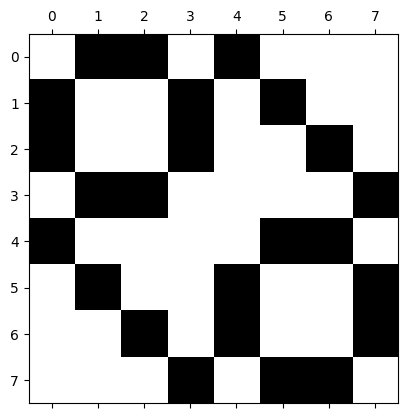

In [72]:

m = generate_sparse_matrix(1)

print(m)
show_array(m.toarray(), "")
G = Graph(m)

In [73]:
len(G.E)

24

In [ ]:
def asymmetrical_elimination(M):
    G = Graph(M)
    for k in range(M.shape[0]):
        succ = {e[1] for e in G.E if e[0] == k}
        pred = {e[0] for e in G.E if e[1] == k}
        G.V = G.V.difference({k})
        G.E = G.E.difference({e for e in G.E if e[1] in succ})
        G.E = G.E.difference({e for e in G.E if e[0] in pred})
        G.E.update({(x, y) for x in pred for y in succ})



# print(m.shape)

In [96]:
def minimum_degree(G : Graph):
    for k in range(G.M.shape[0]):

        p = G.get_min_degree_vertex()
        for v in G.get_neighbors(p):



In [75]:
# df_ss, df_times, df_repr, df_msa = stat_functions([0.01, 0.02, 0.05, 0.1, 0.2])

In [76]:
# df_times.to_csv("df_times.csv", index=True)
# df_msa.to_csv("df_msa.csv", index=True)
# df_times = pd.read_csv("df_times.csv", index_col=0)
# df_msa = pd.read_csv("df_msa.csv", index_col=0)
# def plot_s_values(df, first=False):
#     plt.figure(figsize=(8, 6))
#     for index, row in df.iterrows():
#         if first:
#             plt.plot(row['s'], label=f"Nonzero Percentage: {row['nonzero_percentage']}")
#         else:
#             plt.plot(row['s'][1:], label=f"Nonzero Percentage: {row['nonzero_percentage']}")
#
#     plt.xlabel('Singular Value Index')
#     plt.ylabel('Singular Value')
#     plt.legend()
#     if first:
#         plt.title('Singular Values vs Nonzero Percentage')
#     else:
#         plt.title('Singular Values (without first) vs Nonzero Percentage')
#     plt.show()
# plot_s_values(df_ss)
# plot_s_values(df_ss, True)
# df_ss

In [77]:
# def plot_times(df_times):
#     plt.figure(figsize=(8, 6))
#     for b_name in df_times['b'].unique():
#         for sigma_name in df_times['sigma'].unique():
#
#             # plot with points and lines
#             plt.plot(df_times[(df_times['b'] == b_name) & (df_times['sigma'] == sigma_name)]['nonzero_percentage'],
#                      df_times[(df_times['b'] == b_name) & (df_times['sigma'] == sigma_name)]['time'],
#                      label=f"b: {b_name[-1]}, delta: {sigma_name}")
#             plt.scatter(df_times[(df_times['b'] == b_name) & (df_times['sigma'] == sigma_name)]['nonzero_percentage'], df_times[(df_times['b'] == b_name) & (df_times['sigma'] == sigma_name)]['time'])
#
#
#     plt.xlabel('Nonzero Percentage')
#     plt.ylabel('Time')
#     plt.legend()
#     plt.title('Time vs Nonzero Percentage')
#     plt.show()
#
# plot_times(df_times)

In [78]:
# def plot_msa(df_msa, log=True):
#     plt.figure(figsize=(8, 6))
#     for b_name in df_msa['b'].unique():
#         for sigma_name in df_msa['sigma'].unique():
#
#             # plot with points and lines
#             plt.plot(df_msa[(df_msa['b'] == b_name) & (df_msa['sigma'] == sigma_name)]['nonzero_percentage'],
#                      df_msa[(df_msa['b'] == b_name) & (df_msa['sigma'] == sigma_name)]['msa'],
#                      label=f"b: {b_name[-1]}, delta: {sigma_name}")
#             plt.scatter(df_msa[(df_msa['b'] == b_name) & (df_msa['sigma'] == sigma_name)]['nonzero_percentage'], df_msa[(df_msa['b'] == b_name) & (df_msa['sigma'] == sigma_name)]['msa'])
#     # add log scale
#
#     if log:
#         plt.yscale('log')
#
#     plt.xlabel('Nonzero Percentage')
#     plt.ylabel('MSA')
#     plt.legend()
#     plt.title('MSA vs Nonzero Percentage')
#     plt.show()
#
# plot_msa(df_msa)
# plot_msa(df_msa, False)

In [79]:
# def plot_repr(df_repr):
#     plt.figure(figsize=(8, 6))
#     for b_name in df_repr['b'].unique():
#         for sigma_name in df_repr['sigma'].unique():
#             for nonzero_percentage in df_repr['nonzero_percentage'].unique():
#                 print(b_name, sigma_name, nonzero_percentage)
#                 show_array(df_repr[(df_repr['b'] == b_name) & (df_repr['sigma'] == sigma_name) & (df_repr['nonzero_percentage'] == nonzero_percentage)]['repr'].iloc[0], f"nonzero_percentage_{nonzero_percentage}_sigma_{sigma_name}_b_{b_name[-1]}", True)
#
#
# plot_repr(df_repr)